<a href="https://colab.research.google.com/github/axelpuyo/liasd/blob/master/perceptive_bias_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Run once
!pip install import-ipynb

import os
print(os.getcwd())
print(os.listdir())

#%cd your_path
%cd drive/MyDrive/Colab Notebooks/liasd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content
['.config', 'drive', 'sample_data']
/content/drive/MyDrive/Colab Notebooks/liasd


In [ ]:
import cv2
import import_ipynb
import utils
import colored_mnist

import numpy as np
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import tensorflow.keras as keras
import matplotlib.pyplot as plt

11501568/11490434 [==============================] - 0s 0us/step


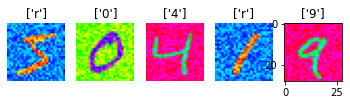

In [ ]:
(train_images, train_colors, train_numbers, train_mixed), (test_images, test_colors, test_numbers, test_mixed) = colored_mnist.load_data(8000)

for i in range(5):
  plt.axis('off')
  plt.subplot(1, 5, i + 1)
  plt.title(utils.uncategoric(train_mixed[i])[0])
  plt.imshow(train_images[i])

In [ ]:
# Color-biased model
color_model = keras.Sequential()
color_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
color_model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
color_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
color_model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same'))
color_model.add(keras.layers.Flatten())
color_model.add(keras.layers.Dense(3))
color_model.add(keras.layers.Softmax())

input_shape = train_images.shape
color_model.build(input_shape)

color_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# color_model.summary()

print('>> Color-biased model training')
color_model.fit(train_images, train_colors, batch_size=12, epochs=5)

>> Color-biased model training
Train on 8000 samples
Epoch 1/5
8000/8000 [==============================] - 10s 1ms/sample - loss: 0.0078 - acc: 0.9969
Epoch 2/5
8000/8000 [==============================] - 3s 326us/sample - loss: 2.9802e-11 - acc: 1.0000
Epoch 3/5
8000/8000 [==============================] - 3s 315us/sample - loss: 0.0000e+00 - acc: 1.0000
Epoch 4/5
8000/8000 [==============================] - 2s 266us/sample - loss: 0.0000e+00 - acc: 1.0000
Epoch 5/5
8000/8000 [==============================] - 2s 262us/sample - loss: 0.0000e+00 - acc: 1.0000


In [ ]:
# Shape-biased model
shape_model = keras.Sequential()
shape_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
shape_model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
shape_model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
shape_model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same'))
shape_model.add(keras.layers.Flatten())
shape_model.add(keras.layers.Dense(10))
shape_model.add(keras.layers.Softmax())

input_shape = train_images.shape
shape_model.build(input_shape)

shape_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# shape_model.summary()

print('>> Shape-biased model training')
shape_model.fit(train_images, train_numbers, batch_size=12, epochs=25, shuffle=True)

In [ ]:
# Rule-biased model
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2), padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(13))
model.add(keras.layers.Softmax())

input_shape = train_images.shape
model.build(input_shape)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

print('>> Rule-biased model training')
model.fit(train_images, train_mixed, batch_size=12, epochs=25)

model.save('saved_models/rule_biased')

>> Rule-biased model training
Train on 8000 samples
Epoch 1/25
8000/8000 [==============================] - 2s 275us/sample - loss: 0.4954 - acc: 0.8407
Epoch 2/25
8000/8000 [==============================] - 2s 261us/sample - loss: 0.1272 - acc: 0.9638
Epoch 3/25
8000/8000 [==============================] - 2s 296us/sample - loss: 0.0805 - acc: 0.9772
Epoch 4/25
8000/8000 [==============================] - 2s 278us/sample - loss: 0.0634 - acc: 0.9822
Epoch 5/25
8000/8000 [==============================] - 2s 263us/sample - loss: 0.0493 - acc: 0.9854
Epoch 6/25
8000/8000 [==============================] - 2s 260us/sample - loss: 0.0380 - acc: 0.9891
Epoch 7/25
8000/8000 [==============================] - 2s 263us/sample - loss: 0.0299 - acc: 0.9927
Epoch 8/25
8000/8000 [==============================] - 2s 261us/sample - loss: 0.0220 - acc: 0.9942
Epoch 9/25
8000/8000 [==============================] - 2s 262us/sample - loss: 0.0181 - acc: 0.9960
Epoch 10/25
8000/8000 [================